In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

from tqdm.notebook import tqdm # progress bar


In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


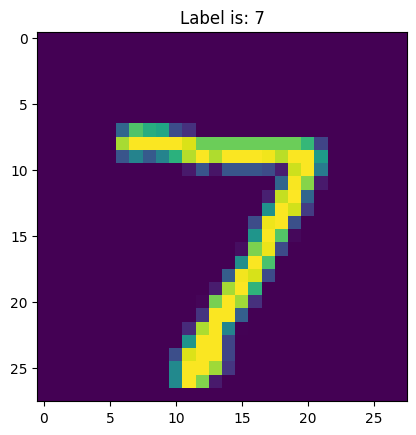

In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    plt.imshow(X[0][0])
    
    plt.title(f"Label is: {y[0]}")
    plt.show()
    
    break


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


## Model

In [11]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, img_shape),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_shape, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



## Training

[Epoch 1/30]  D loss: 1.4022  G loss: 1.5521


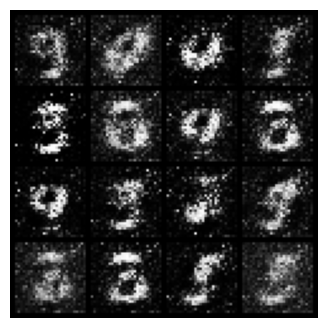

[Epoch 2/30]  D loss: 1.1106  G loss: 1.1883


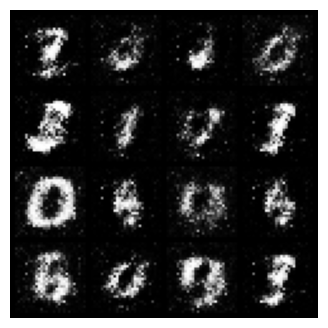

[Epoch 3/30]  D loss: 1.1616  G loss: 1.2926


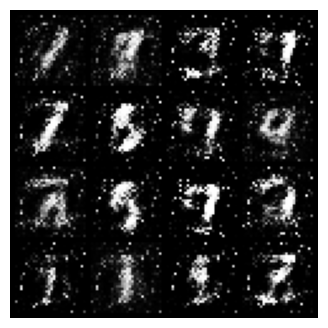

[Epoch 4/30]  D loss: 1.3652  G loss: 1.7827


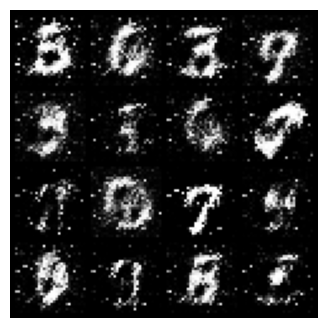

[Epoch 5/30]  D loss: 1.2298  G loss: 1.2510


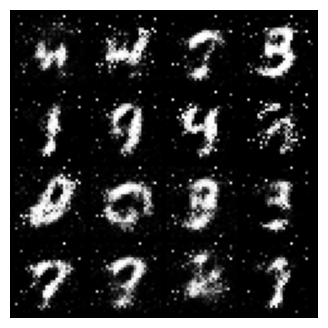

[Epoch 6/30]  D loss: 1.2012  G loss: 1.4798


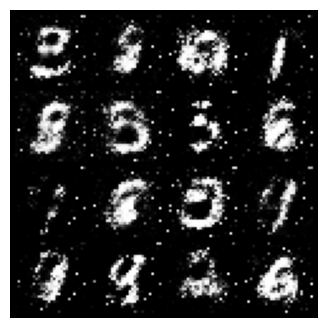

[Epoch 7/30]  D loss: 1.2059  G loss: 1.6422


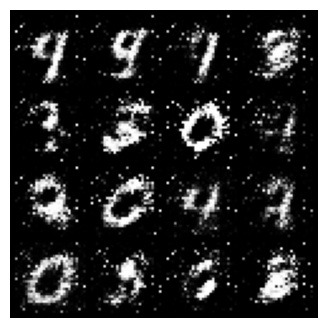

[Epoch 8/30]  D loss: 1.4631  G loss: 1.6372


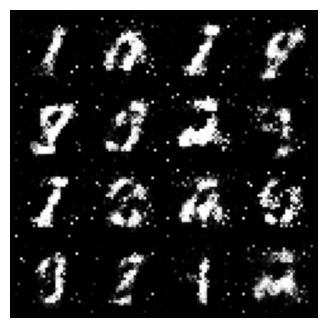

[Epoch 9/30]  D loss: 1.2913  G loss: 1.6230


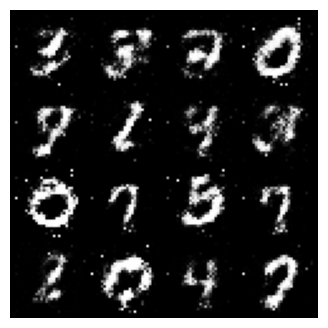

[Epoch 10/30]  D loss: 1.2054  G loss: 1.4873


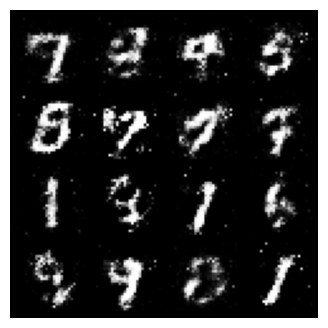

[Epoch 11/30]  D loss: 1.2463  G loss: 1.7709


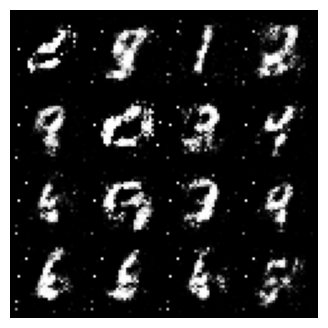

[Epoch 12/30]  D loss: 0.8068  G loss: 3.1646


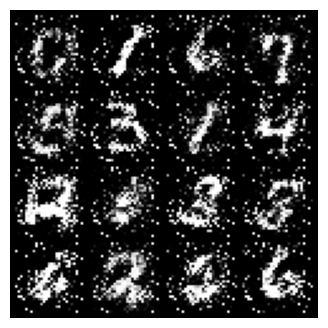

[Epoch 13/30]  D loss: 1.1412  G loss: 1.3568


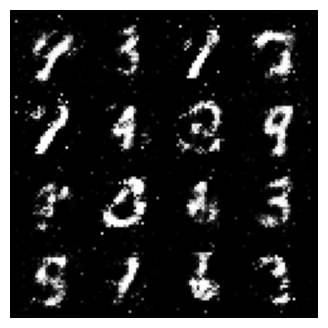

[Epoch 14/30]  D loss: 1.2354  G loss: 2.0372


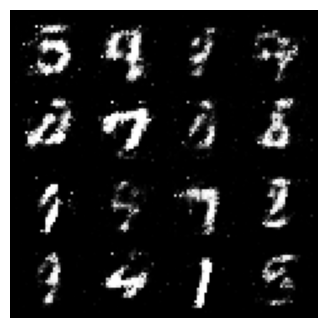

[Epoch 15/30]  D loss: 1.2927  G loss: 1.8752


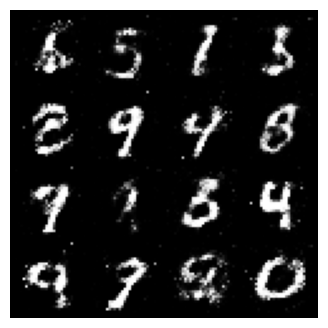

[Epoch 16/30]  D loss: 1.3506  G loss: 1.7353


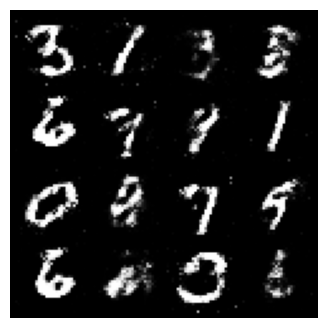

[Epoch 17/30]  D loss: 1.2025  G loss: 1.8417


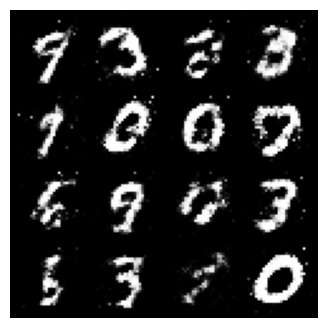

[Epoch 18/30]  D loss: 1.0817  G loss: 1.5072


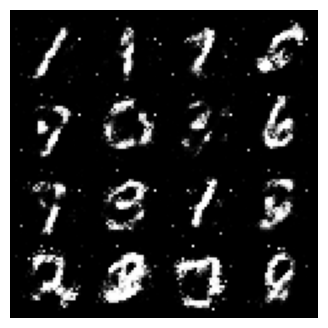

[Epoch 19/30]  D loss: 1.1572  G loss: 2.5427


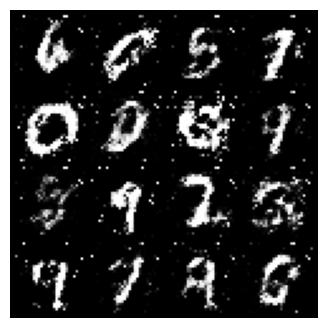

[Epoch 20/30]  D loss: 1.3487  G loss: 1.8482


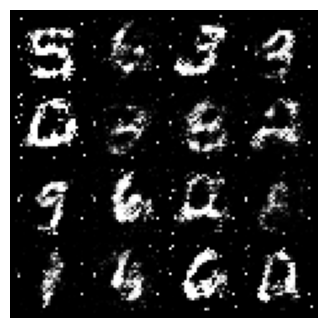

[Epoch 21/30]  D loss: 1.2103  G loss: 1.8458


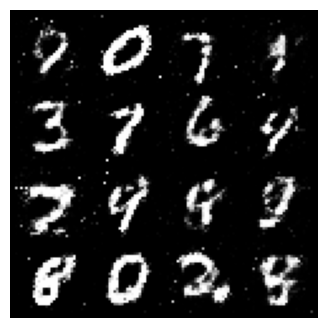

[Epoch 22/30]  D loss: 1.2036  G loss: 1.5574


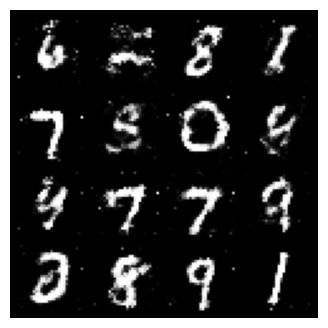

[Epoch 23/30]  D loss: 1.1771  G loss: 1.2866


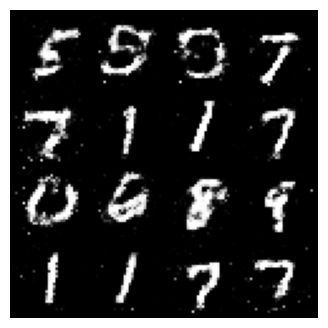

[Epoch 24/30]  D loss: 1.2584  G loss: 1.4066


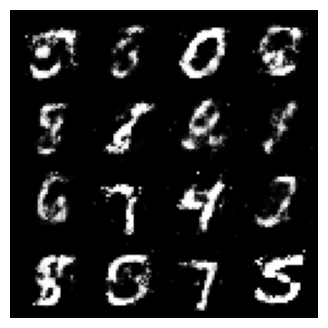

[Epoch 25/30]  D loss: 0.9639  G loss: 1.4367


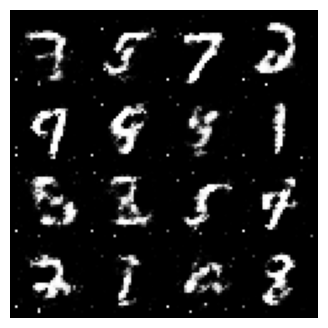

[Epoch 26/30]  D loss: 1.2004  G loss: 1.7251


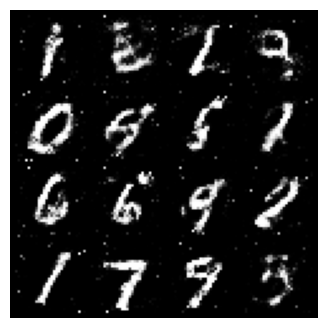

[Epoch 27/30]  D loss: 1.1306  G loss: 1.5759


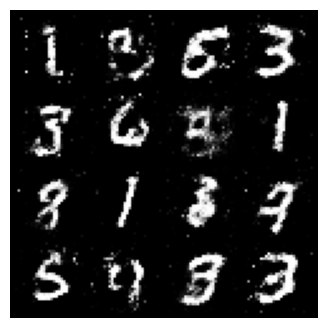

In [ ]:
latent_dim = 100
img_shape = 28 * 28
lr = 0.0003

# Initialize models
G = Generator(latent_dim).to(device)
D = Discriminator(img_shape).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

num_epochs = 30
# Training loop
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.view(-1, img_shape).to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)  # want D to think fakes are real

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{num_epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}")

    # Show sample images every few epochs
    if (epoch + 1) % 1 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            samples = G(z).view(-1, 1, 28, 28)
            samples = samples * 0.5 + 0.5  # rescale to [0,1]
            grid = torchvision.utils.make_grid(samples, nrow=4)
            plt.figure(figsize=(4,4))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis("off")
            plt.show()
        G.train()
